# Predicting Falcon 9 First Stage Landing Success Using SpaceX Launch Data
This project focuses on predicting whether the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 launches at around $62 million, while competitors often charge over $165 million. A large part of SpaceX’s cost advantage comes from reusing the first stage. By predicting the likelihood of a successful landing, we can estimate the potential cost efficiency of a launch. This information could be useful for companies looking to compete with SpaceX in the rocket launch market. In this project, launch data is collected from the SpaceX API, cleaned, and prepared for analysis, with the goal of building a predictive model for first-stage landing success.

Falcon 9 first stage will land successfully


![](./assets/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](./assets/crash.gif)


Necessary libraries

In [165]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Datetime is a library that allows us to represent dates
import datetime
# Pandas for data manipulation and analysis.
import pandas as pd
# NumPyfor adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn for high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier


## Data Collecting

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the rocket column we would like to learn the booster name.



In [168]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the launchpad we would like to know the name of the launch site being used, the logitude, and the latitude.

In [170]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the payload we would like to learn the mass of the payload and the orbit that it is going to.

In [172]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [175]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:



In [177]:
spacex_url="https://api.spacexdata.com/v4/launches/past"


In [178]:
response = requests.get(spacex_url)
print(response.content)


b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

Now we decode the response content as a Json using .json() and turn it into a Pandas dataframe using .json_normalize()

In [180]:
data = pd.json_normalize(response.json())


Using the dataframe data print the first 5 rows

In [182]:
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns rocket, payloads, launchpad, and cores.

In [184]:
# Lets take a subset of the dataframe keeping only the features we want like the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

Now we will use the functions we defiend earlier to:
From the rocket we would like to learn the booster name



*   From the payload we would like to learn the mass of the payload and the orbit that it is going to
*   From the launchpad we would like to know the name of the launch site being used, the longitude, and the latitude.

* From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.





In [186]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

To have better understanding let's take a looks at BoosterVersion variable. Before we apply getBoosterVersion

In [188]:
BoosterVersion

[]

As we can see above the list is empty, Now let's apply  getBoosterVersion function method to get the booster version

In [190]:
# Call getBoosterVersion
getBoosterVersion(data)

the list has now been update

In [192]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

Now let's apply the rest of the functions

In [194]:
# Call getLaunchSite
getLaunchSite(data)
# Call getPayloadData
getPayloadData(data)
# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.

In [196]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

Then, we need to create a Pandas data frame from the dictionary launch_dict.



In [198]:
data = pd.DataFrame(launch_dict)
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


Since we are only interested on Falcon9(reusable rocket) we will remove the Falcon 1 launches keeping only the Falcon 9 launches

In [200]:
data_falcon9 = data[data['BoosterVersion']!='Falcon 1']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


Now that we have removed some values we should reset the FlgihtNumber column

In [202]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


## Data Wrangling
We can see below that some of the rows are missing values in our dataset.

In [204]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

For Dealing with Missing Values i will Calculate the mean for the PayloadMass using the .mean(). Then use the mean and the .replace() function to replace np.nan values in the data with the mean you calculated.

In [206]:
# Calculate the mean value of PayloadMass column
payload_mean = data_falcon9['PayloadMass'].mean()

# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, payload_mean)
data_falcon9.isnull().sum()

C:\Users\Faisa\AppData\Local\Temp\ipykernel_6996\4086550496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, payload_mean)


FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Missing landing pads just mean the rocket wasn’t meant to land. We don’t fill them in because it’s not a mistake, it’s how the data works.

We can now export it to a CSV

In [208]:
data_falcon9['Outcome'].value_counts()

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

In [209]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

## Data Visualisation

#### Data Visualisation with sqlite

Let us first load the SQL extension and establish a connection with the database


In [213]:
!pip install ipython-sql
!pip install ipython-sql prettytable

In [214]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [215]:
import sqlite3
import prettytable
prettytable.DEFAULT = 'DEFAULT'

con = sqlite3.connect("falcon9.db")
cur = con.cursor()

In [216]:
df = pd.read_csv("dataset_part_1.csv")
df.to_sql("falcon9_launches", con, if_exists='replace', index=False,method="multi")

90

1- Unique Launch Sites: all launch sites used for Falcon 9 launches. for understanding launch location distribution.

In [218]:
%sql sqlite:///falcon9.db

In [219]:
%%sql SELECT DISTINCT "LaunchSite"
FROM falcon9_launches;

 * sqlite:///falcon9.db
Done.


LaunchSite
CCSFS SLC 40
VAFB SLC 4E
KSC LC 39A


2- Count of Launches per Launch Site: Counts the number of launches at each site.  for visualizing which sites are most frequently used.

In [221]:
%%sql SELECT "LaunchSite", COUNT(*) AS launch_count
FROM falcon9_launches
GROUP BY "LaunchSite"
ORDER BY launch_count DESC;

 * sqlite:///falcon9.db
Done.


LaunchSite,launch_count
CCSFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


3- Success vs Failure Counts: Counts the number of successful and failed launches (based on Outcome). to evaluate reliability.

In [223]:
%%sql SELECT "Outcome", COUNT(*) AS count
FROM falcon9_launches
GROUP BY "Outcome";

 * sqlite:///falcon9.db
Done.


Outcome,count
False ASDS,6
False Ocean,2
False RTLS,1
None ASDS,2
None None,19
True ASDS,41
True Ocean,5
True RTLS,14


4- Failures by Landing Outcome: Shows the number of failed landings (or missing landings) per type. Helps understand recovery success patterns.

In [225]:
%%sql SELECT "LaunchSite", COUNT(*) AS failures
FROM falcon9_launches
WHERE "Outcome" LIKE 'False%' OR "Outcome" LIKE 'None%'
GROUP BY "LaunchSite"
ORDER BY failures DESC;


 * sqlite:///falcon9.db
Done.


LaunchSite,failures
CCSFS SLC 40,22
KSC LC 39A,5
VAFB SLC 4E,3


5- Payload Distribution by Orbit: Shows average payload mass per orbit type. Useful to see which orbits tend to carry heavier payloads.

In [227]:
%%sql SELECT "Orbit", AVG("PayloadMass") AS avg_payload, COUNT(*) AS launches
FROM falcon9_launches
GROUP BY "Orbit"
ORDER BY avg_payload DESC;


 * sqlite:///falcon9.db
Done.


Orbit,avg_payload,launches
VLEO,15428.57142857143,14
PO,7583.666666666667,9
SO,6123.547647058824,1
GEO,6123.547647058824,1
GTO,5011.9944444444445,27
MEO,3987.0,3
LEO,3890.8061344537814,7
ISS,3279.9380952380952,21
SSO,2060.0,5
ES-L1,570.0,1


6- Launches Over Time (Yearly):Counts launches per year. to visualize launch frequency trends over time.

In [229]:
%%sql SELECT substr("Date",1,4) AS year, COUNT(*) AS launches
FROM falcon9_launches
GROUP BY year
ORDER BY year;

 * sqlite:///falcon9.db
Done.


year,launches
2010,1
2012,1
2013,3
2014,6
2015,6
2016,8
2017,18
2018,18
2019,10
2020,19


### Data Visualisation with Python

First We will create a new column Class to indicate launch success: 1 for successful outcomes (True ASDS, True RTLS, True Ocean) and 0 for failures or unknown outcomes. This numeric column makes it easier to visualize success vs failure and is essential for analyzing launch patterns or building predictive models.

In [232]:
df = pd.read_csv("dataset_part_1.csv")
df['Outcome'].value_counts()

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

In [233]:
success_outcomes = ["True ASDS", "True RTLS", "True Ocean"]

# Create Class column
df['Class'] = df['Outcome'].apply(lambda x: 1 if x in success_outcomes else 0)

# Quick check
df['Class'].value_counts()

Class
1    60
0    30
Name: count, dtype: int64

now let's try to see how the FlightNumber (indicating the continuous launch attempts.) and Payload variables would affect the launch outcome.

1- We can plot out the FlightNumber vs. PayloadMassand overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass also appears to be a factor; even with more massive payloads, the first stage often returns successfully.

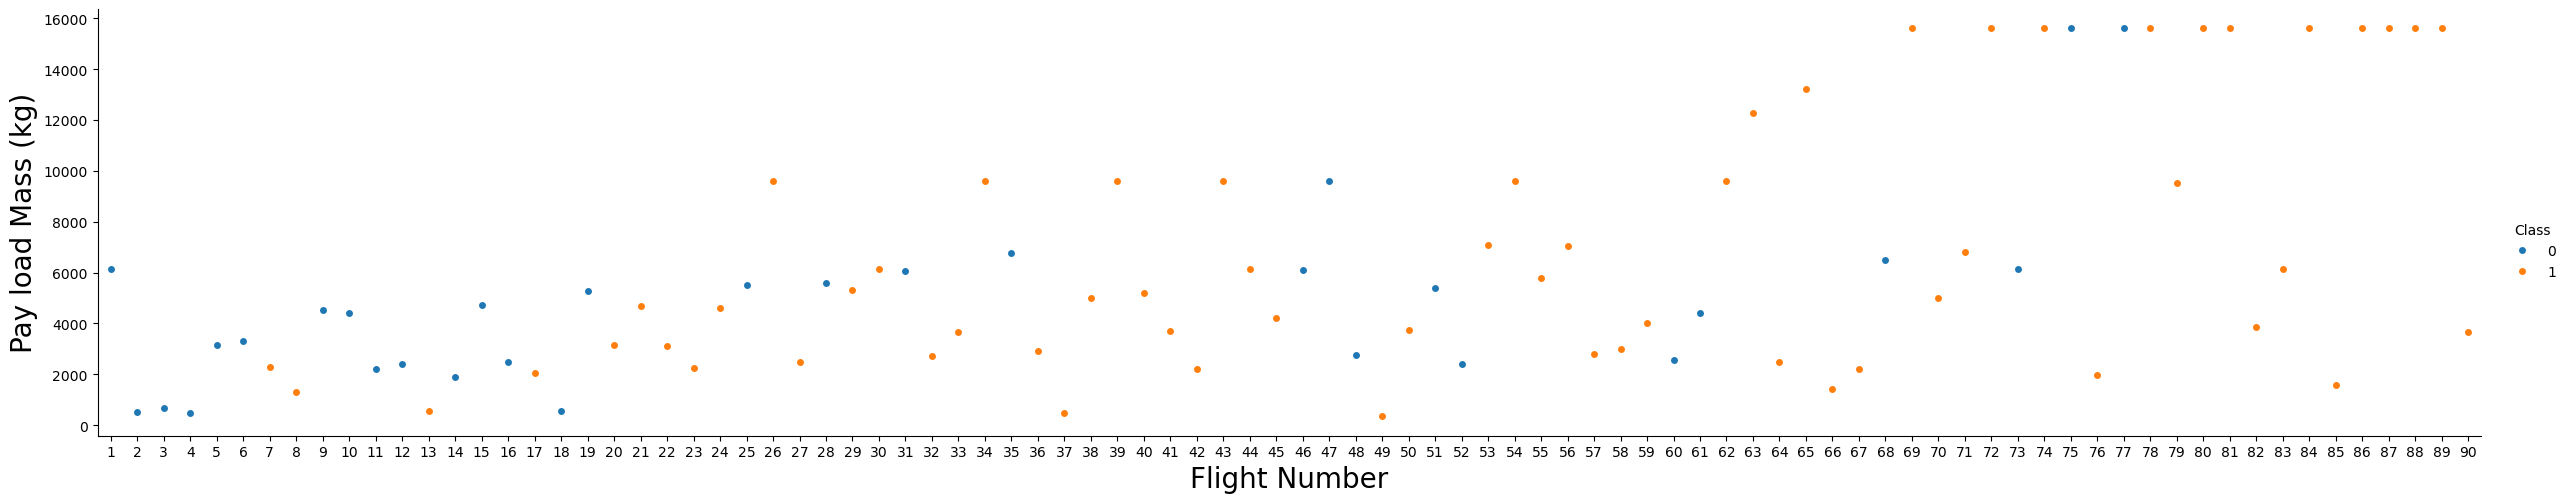

In [235]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

2- We visualize the relationship between FlightNumber and LaunchSite using a categorical plot. The FlightNumber is plotted on the x-axis, LaunchSite on the y-axis, and the Class column (launch success) is used as the hue. This allows us to see how launch outcomes vary across different launch sites and flight sequences.

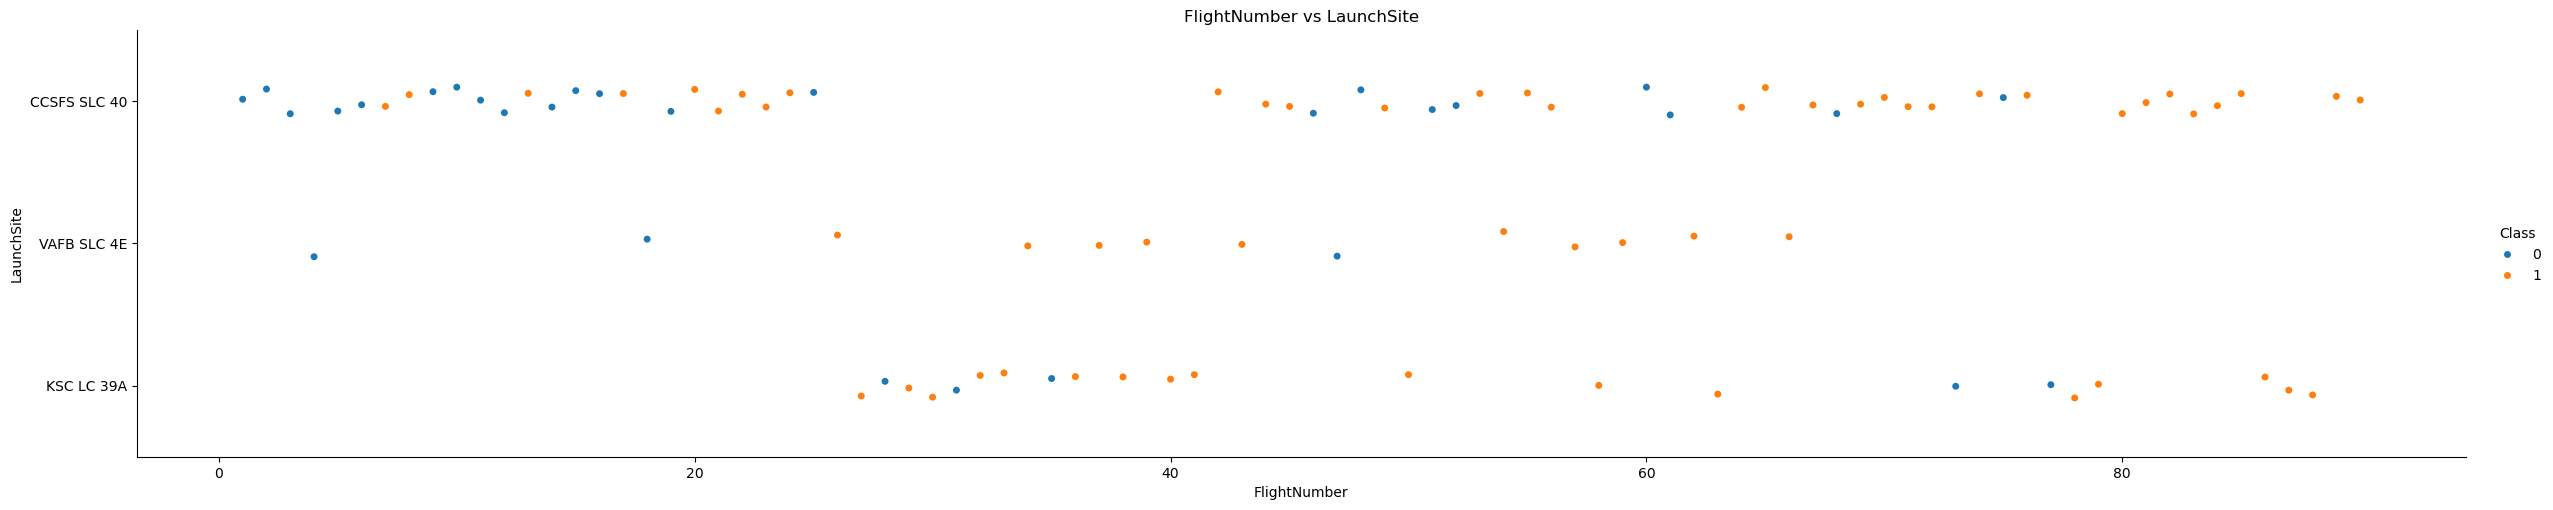

In [237]:
sns.catplot(y='LaunchSite',x='FlightNumber',hue='Class',data=df,aspect=5)
plt.title('FlightNumber vs LaunchSite')
plt.xlabel('FlightNumber')
plt.ylabel('LaunchSite')
plt.show()

3- We visualize the relationship between PayloadMass and LaunchSite to observe how payload weight varies across different launch sites. This helps identify any patterns or trends between launch site and payload capacity.

Note: if we observe Payload Mass Vs. Launch Site scatter point chart we will find for the VAFB-SLC launchsite there are no rockets launched for heavypayload mass(greater than 10000).

<Axes: xlabel='PayloadMass', ylabel='LaunchSite'>

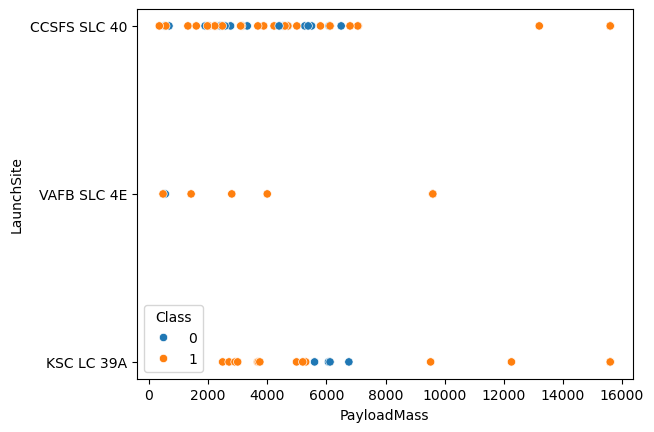

In [239]:
sns.scatterplot(x='PayloadMass',y='LaunchSite',hue='Class',data=df)

4- We visualize the success rate for each Orbit type using a bar chart. This allows us to see how launch outcomes vary across different orbits and identify patterns in success rates.

Note: We can see that
- ES-L1
- GEO
- HEO
- SSO

have the highest success rates.

<Axes: xlabel='Orbit', ylabel='Class'>

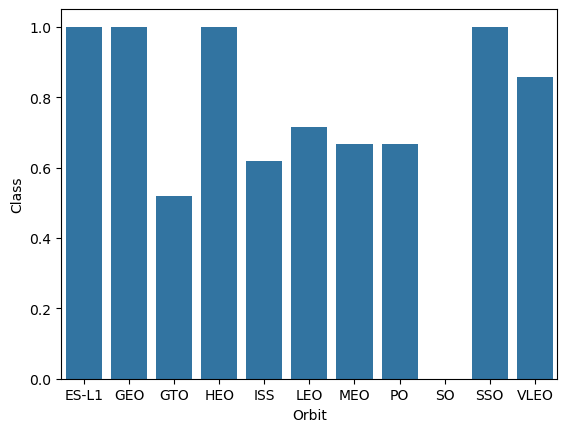

In [241]:
orbit = df.groupby('Orbit')['Class'].mean()


sns.barplot(orbit)

5- We visualize the relationship between FlightNumber and Orbit type to see how different orbits are distributed across successive launches and identify any patterns in orbit selection over time.

Note: we can observe that in the LEO orbit, success seems to be related to the number of flights. Conversely, in the GTO orbit, there appears to be no relationship between flight number and success.

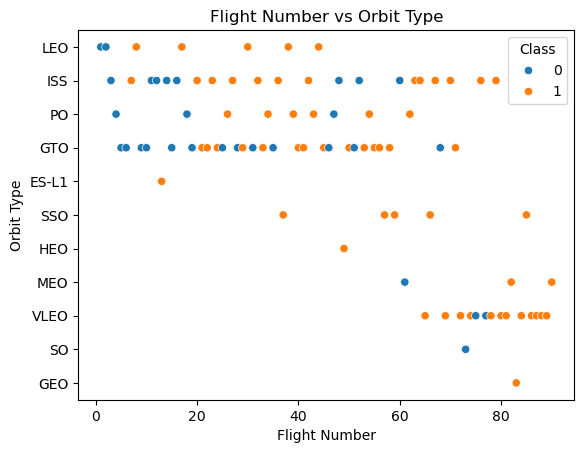

In [243]:
sns.scatterplot(x='FlightNumber', y='Orbit', hue='Class', data=df)
plt.title("Flight Number vs Orbit Type")
plt.xlabel("Flight Number")
plt.ylabel("Orbit Type")
plt.show()

6- We visualize the relationship between PayloadMass and Orbit type using a scatter plot. This helps reveal how payload weight varies across different orbit types and identify patterns in payload distribution.

Note: With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.

However, for GTO, it's difficult to distinguish between successful and unsuccessful landings as both outcomes are present.

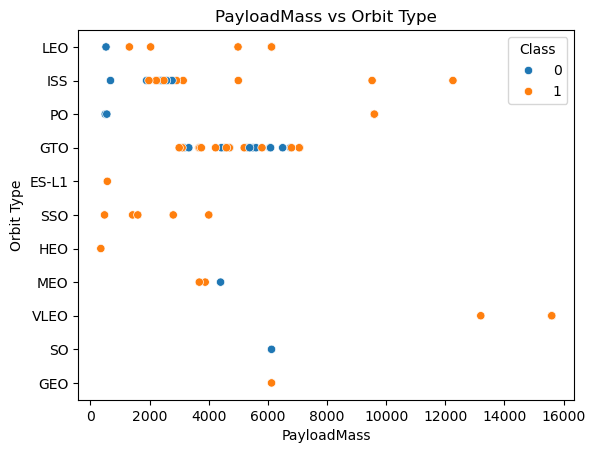

In [245]:
sns.scatterplot(x='PayloadMass', y='Orbit', hue='Class', data=df)
plt.title("PayloadMass vs Orbit Type")
plt.xlabel("PayloadMass")
plt.ylabel("Orbit Type")
plt.show()

7- We visualize the yearly launch success trend using a line chart. The x-axis represents the Year (extracted from the launch Date), and the y-axis shows the average Class (success rate). This helps track how launch success has evolved over time.

Note: you can observe that the sucess rate since 2013 kept increasing till 2020



In [247]:
# A function to Extract years from the date
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


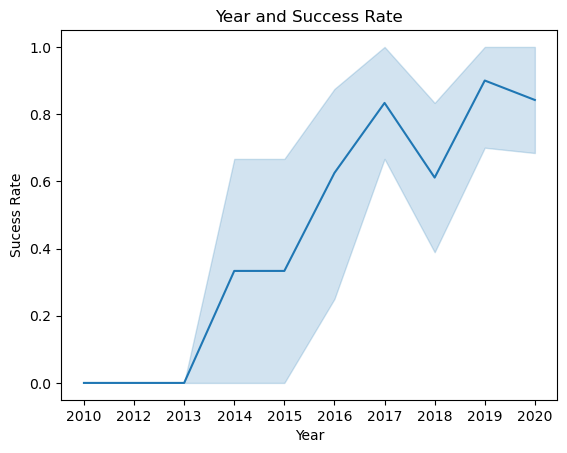

In [248]:
sns.lineplot(x='Date', y=df['Class'] , data=df)
plt.title("Year and Success Rate")
plt.xlabel('Year')
plt.ylabel('Sucess Rate')
plt.show()

## Feature Engineering

At this stage, we have gathered preliminary insights on how key variables affect launch success. These observations will guide the selection of features to be used in building predictive models.

In [251]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial','Class']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Class
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003,0
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005,0
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007,0
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003,0
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004,0


We convert categorical columns (Orbit, LaunchSite, LandingPad, and Serial) into dummy variables using one-hot encoding. This creates numeric representations of categorical features, which are required for machine learning models. The resulting dataframe, features_one_hot, includes all original features along with the encoded columns.

In [253]:
features_one_hot = pd.get_dummies(features,columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,0,False,...,False,False,False,False,False,False,False,False,False,False


Since features_one_hot now contains only numeric values, we cast all columns to float64. This ensures consistency in data types, which is important for machine learning algorithms.

In [255]:
features_one_hot = features_one_hot.astype(float)
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 81, dtype: object

We can now export the prepared features_one_hot dataframe to a CSV file (features_one_hot.csv) for Modeling

In [257]:
pd.DataFrame(features_one_hot).to_csv('features_one_hot.csv', index=False)

### Modeling


First we will define a function to plot the confusion matrix. which will be used later for comparison

In [260]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

Load the data


In [262]:
data = pd.read_csv('features_one_hot.csv')

data.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Class,Orbit_ES-L1,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We extract the Class column from the dataset and convert it into a NumPy array using the to_numpy() method. This array, stored in Y, represents the target variable (launch success) and will be used for training and evaluating machine learning models.

In [264]:
y = data['Class'].to_numpy()
y

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

Then we standardize the feature data in X to ensure all variables are on the same scale. This transformation improves the performance and stability of many machine learning algorithms by preventing features with larger values from dominating the model.

In [266]:
transform = preprocessing.StandardScaler()
X = data.drop(['Class'], axis=1)
X = transform.fit_transform(X)
X

array([[-1.71291154,  0.        , -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.67441914, -1.18972425, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.63592675, -1.15742336, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [ 1.63592675,  2.01380177,  3.49060516, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [ 1.67441914,  2.01380177,  1.00389436, ..., -0.21566555,
         5.38516481, -0.10599979],
       [ 1.71291154, -0.51905572, -0.65391284, ..., -0.21566555,
        -0.18569534,  9.43398113]])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


In [268]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

we can see we only have 18 test samples.


In [270]:
Y_test.shape

(18,)

#### Logistic Regression

We create a Logistic Regression model and use GridSearchCV with 10-fold cross-validation to find the best hyperparameters. The grid searches over different values of C, which controls the strength of regularization, while using L2 regularization (penalty='l2') and the lbfgs solver. This process helps identify the model configuration that provides the best performance on the training data.

In [273]:
parameters ={'C':[0.01,0.1,1],'penalty':['l2'],'solver':['lbfgs']}# l1 lasso l2 ridge


In [274]:
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr,parameters, cv = 10)
logreg_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [276]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


The accuracy on the test data using the method <code>score</code>:


In [278]:
logreg_cv.score(X_test,Y_test)

0.8333333333333334

Lets look at the confusion matrix:


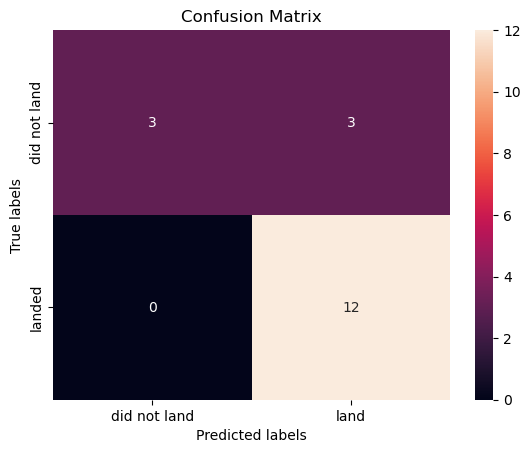

In [280]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


#### Support Vector Machine(SVM)

We create a Support Vector Machine (SVM) classifier and apply GridSearchCV with 10-fold cross-validation to tune its hyperparameters. The grid explores different kernel functions, values of C (regularization strength), and gamma (influence of individual data points). This process identifies the optimal SVM configuration that best separates successful and unsuccessful launches.

In [284]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

In [285]:
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [286]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


The accuracy on the test data using the method <code>score</code>:


In [288]:
svm_cv.score(X_test,Y_test)

0.8333333333333334

We can plot the confusion matrix


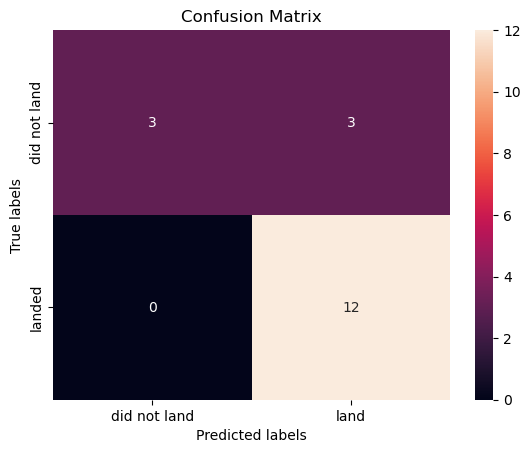

In [290]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Decision Tree Classifier

We create a Decision Tree classifier and use GridSearchCV with 10-fold cross-validation to tune its hyperparameters. The grid evaluates different splitting criteria, tree depths, feature selection strategies, and minimum sample requirements. This helps find the optimal tree structure that balances model complexity and predictive performance.

In [396]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt', 'log2', None],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

In [398]:
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [399]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8892857142857142


The accuracy of tree_cv on the test data using the method <code>score</code>:


In [400]:
tree_cv.score(X_test,Y_test)

0.8333333333333334

We can plot the confusion matrix


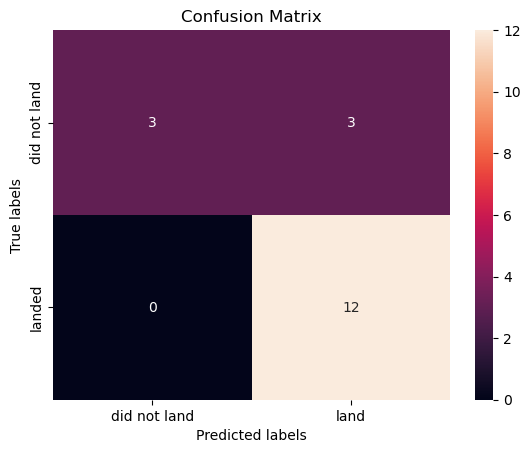

In [404]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### K-Nearest Neighbors (KNN) classifier

We create a K-Nearest Neighbors (KNN) classifier and apply GridSearchCV with 10-fold cross-validation to tune its hyperparameters. The grid tests different numbers of neighbors, search algorithms, and distance metrics (p=1 for Manhattan distance and p=2 for Euclidean distance). This process identifies the KNN configuration that yields the best prediction performance.

In [424]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

In [426]:
KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [427]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


The accuracy of knn_cv on the test data using the method <code>score</code>:


In [430]:
knn_cv.score(X_test,Y_test)

0.7777777777777778

We can plot the confusion matrix


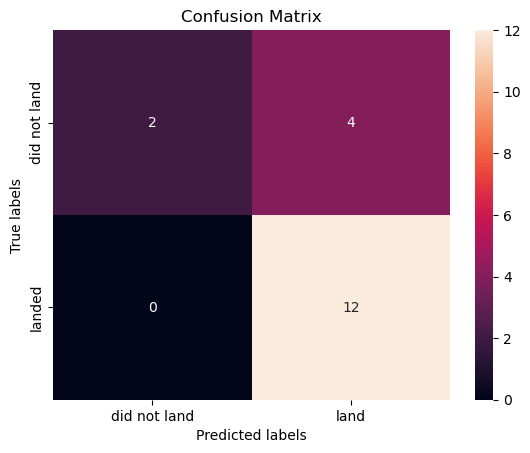

In [432]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Comparison

First We evaluate all trained models on both the training and test datasets to compare their performance. For each model, we report training accuracy, test accuracy, and the best hyperparameters found during cross-validation. This comparison helps identify the model that generalizes best to unseen data based on test accuracy.

In [418]:
# Evaluate all models on test data
models = {
    'Logistic Regression': logreg_cv,
    'Decision Tree': tree_cv,
    'SVM': svm_cv,
    'KNN': knn_cv,
}

# Compare test scores
print("Model Performance Comparison:")
print("-" * 50)

results = {}
for name, model in models.items():
    test_score = model.score(X_test, Y_test)
    train_score = model.score(X_train, Y_train)
    results[name] = {'test': test_score, 'train': train_score}

    print(f"{name}:")
    print(f"  Training Accuracy: {train_score:.4f}")
    print(f"  Test Accuracy: {test_score:.4f}")
    print(f"  Best Parameters: {model.best_params_}")
    print()

# best model
best_model_name = max(results, key=lambda x: results[x]['test'])
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test']:.4f}")

Model Performance Comparison:
--------------------------------------------------
Logistic Regression:
  Training Accuracy: 0.9722
  Test Accuracy: 0.8333
  Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Decision Tree:
  Training Accuracy: 0.9306
  Test Accuracy: 0.8333
  Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}

SVM:
  Training Accuracy: 0.9028
  Test Accuracy: 0.8333
  Best Parameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}

KNN:
  Training Accuracy: 0.8333
  Test Accuracy: 0.7778
  Best Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}

Best Model: Logistic Regression
Test Accuracy: 0.8333


Visualize the results of All models using a bar chart.

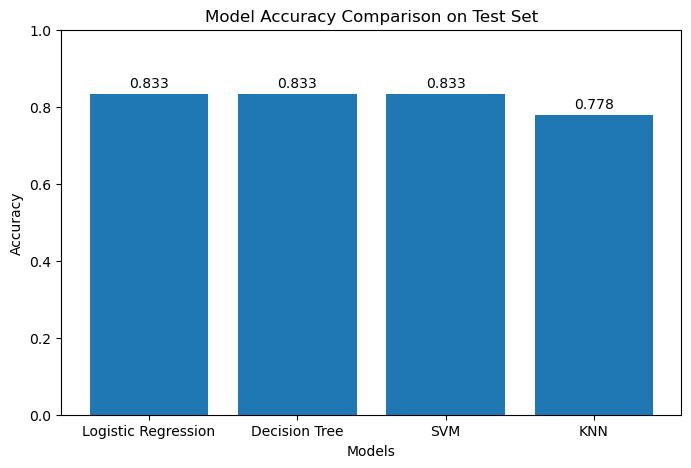

In [420]:
# 1. Import matplotlib for plotting
import matplotlib.pyplot as plt

models_list = list(results.keys())
accuracies = [results[m]['test'] for m in models_list]

plt.figure(figsize=(8, 5))
bars = plt.bar(models_list, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison on Test Set')
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.01,
             f'{acc:.3f}',
             ha='center', va='bottom')

plt.show()


Visualize the results of All models using a confusion matrix.

Logistic Regression Confusion Matrix


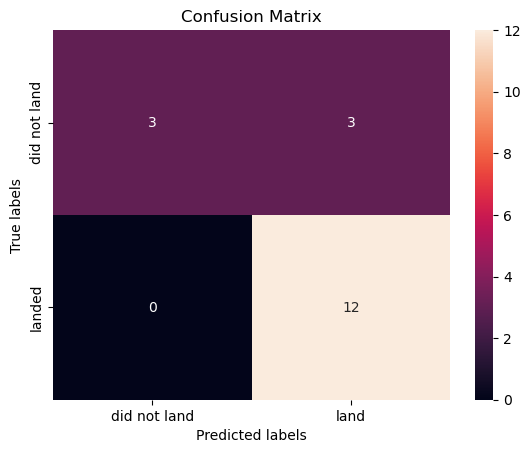

Decision Tree Confusion Matrix


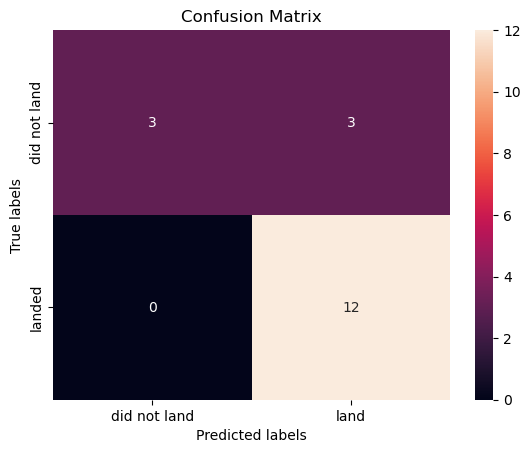

SVM Confusion Matrix


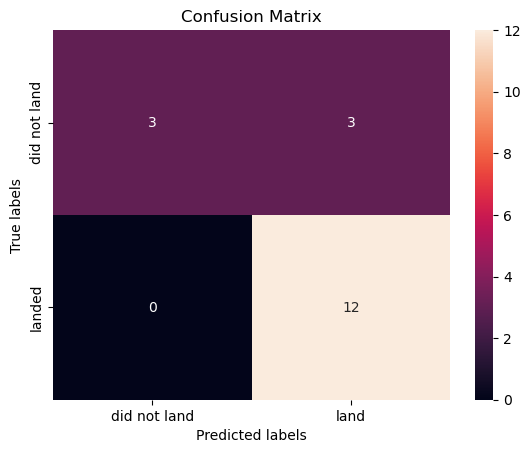

KNN Confusion Matrix


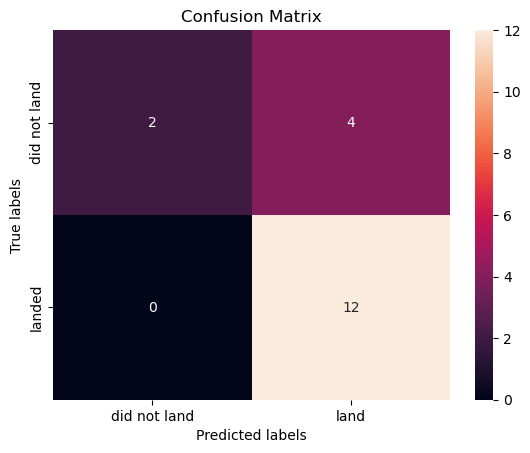

In [422]:
# 3. Plot confusion matrices
for name, model in models.items():
    print(f"{name} Confusion Matrix")
    Y_pred = model.predict(X_test)
    plot_confusion_matrix(Y_test, Y_pred)



### Conclusion

Multiple machine learning models were evaluated to predict Falcon 9 launch success. Logistic Regression, Decision Tree, and Support Vector Machine (SVM) all achieved the highest test accuracy of 83.33%, indicating comparable generalization performance on unseen data.

Logistic Regression was selected as the best model due to its strong test performance combined with the highest training accuracy, reflecting a stable and well-regularized decision boundary. The Decision Tree also performed competitively, offering greater model interpretability, while SVM achieved similar accuracy using a more complex kernel.

In contrast, K-Nearest Neighbors (KNN) showed lower test accuracy, suggesting reduced effectiveness for this dataset. Overall, the results demonstrate that well-regularized, simpler models can effectively predict launch success when supported by appropriate feature engineering.
